In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2603ced8898>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

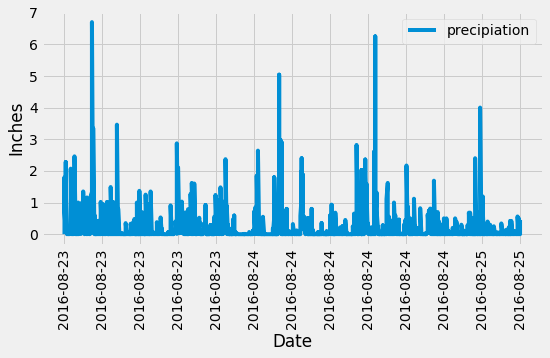

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
session.query(Measurement).first()

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(func.max(Measurement.date)).first()
max_date = pd.to_datetime(max_date)
min_date = dt.date(max_date[0].year, max_date[0].month, max_date[0].day) - dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > min_date).\
    filter(Measurement.prcp != None).\
    order_by(Measurement.date).all()
dates = [result[0] for result in prcp_data]
prcp = [result[1] for result in prcp_data]

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['dates', 'prcp'])
prcp_df.set_index('dates', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
tick_spacing = 365/12
fig, ax = plt.subplots(1,1)
fig.set_size_inches(8, 4)
prcp_plot = ax.plot(dates, prcp)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_xticklabels(labels=dates, rotation=90)
ax.set_ylabel(ylabel='Inches')
ax.set_xlabel(xlabel='Date')
ax.legend(['precipiation'], loc='best')

plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_stn = session.query(Measurement.station).distinct(Measurement.station).count()
num_stn

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stn_activity = session.query(Measurement.station, func.count(Measurement.station).label('qty')).\
    group_by(Measurement.station).\
    order_by(desc('qty')).all()

stn_df = pd.DataFrame(stn_activity, columns=['station', 'qty'])
stn_df

,station,qty
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
stn_tobs = session.query(Measurement.station, func.count(Measurement.station).label('qty'),
                         func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station.in_(stn_df['station'])).\
    group_by(Measurement.station).\
    order_by(desc('qty')).all()

tobs_df = pd.DataFrame(stn_tobs, columns=['station', 'qty', 'low_tobs', 'high_tobs', 'avg_tobs'])

print(f'station with highest number of observations: {tobs_df["station"][0]}')
print(f'lowest temp = {tobs_df["low_tobs"][0]}')
print(f'highest temp = {tobs_df["high_tobs"][0]}')
print(f'average temp = {tobs_df["avg_tobs"][0]}')

tobs_df

station with highest number of observations: USC00519281
lowest temp = 54.0
highest temp = 85.0
average temp = 71.66378066378067


,station,qty,low_tobs,high_tobs,avg_tobs
0,USC00519281,2772,54.0,85.0,71.663781
1,USC00519397,2724,56.0,87.0,74.553231
2,USC00513117,2709,59.0,85.0,72.689184
3,USC00519523,2669,56.0,85.0,74.543649
4,USC00516128,2612,58.0,84.0,70.915008
5,USC00514830,2202,58.0,85.0,74.873297
6,USC00511918,1979,53.0,87.0,71.615968
7,USC00517948,1372,58.0,87.0,74.684402
8,USC00518838,511,58.0,83.0,72.724070


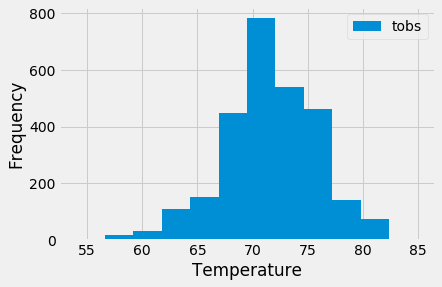

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_stn = tobs_df['station'][0]

top_stn_tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == top_stn).\
    order_by(Measurement.tobs).all()

tobs = [result[0] for result in top_stn_tobs_data]
top_stn_hist = plt.hist(x=tobs, bins=12)
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend(['tobs'], loc='best')

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
